In [ ]:
!kaggle datasets download -d greedyfornothing/multiclass-semantic-ct-scan-liver-tumor

Dataset URL: https://www.kaggle.com/datasets/greedyfornothing/multiclass-semantic-ct-scan-liver-tumor
License(s): unknown
 97% 647M/665M [00:03<00:00, 153MB/s]
100% 665M/665M [00:03<00:00, 183MB/s]


In [ ]:
# Unzipping the file to the current directory or a specified folder
!unzip /content/multiclass-semantic-ct-scan-liver-tumor.zip -d /content/multiclass-semantic-ct-scan-liver-tumor


Streaming output truncated to the last 5000 lines.
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_240.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_241.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_242.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_243.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_244.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_245.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_246.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/volume-122_slice_247.tiff  
  inflating: /content/multiclass-semantic-ct-scan-liver-tumor/Train_C

In [ ]:
# Install a specific version of albumentations that contains JpegCompression and RandomBrightness
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.4 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65153 sha256=d1fb33a624cb9a2ae9cf9ce064428dcf80cfc524d766e324acf217310ec8794b
  Stored in directory: /root/.cache/pip/wheels/b3/d8/61/0fb4a147b5764c28c1a202331f8162e4234803c75d20fb2be5
Successfully built albumentations


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import scienceplots
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2
from albumentations import (
    Compose, RandomBrightnessContrast, ImageCompression, HueSaturationValue, RandomContrast,
    HorizontalFlip, Rotate, GridDistortion, ElasticTransform
)


In [ ]:
transforms = Compose([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5)])

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [ ]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x

In [ ]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)

    train_x = [os.path.join(x_path, image) for image in images]
#     train_y = [os.path.join(y_path, mask) for mask in masks]

    train_y = list(map(lambda x : x.replace('.jpg', '.tiff'), train_x))
    train_y = list(map(lambda x : x.replace('/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan',
                                            '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'), train_y))


    train_x, valid_x = train_test_split(train_x, test_size=0.15, random_state=0)
    train_y, valid_y = train_test_split(train_y, test_size=0.15, random_state=0)

    return (train_x, train_y), (valid_x, valid_y)

In [ ]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size= 5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
def preprocess(x,y):

    def f(x,y):
        x = x.decode()
        y = y.decode()

        image = read_image(x)
        mask = read_mask(y)
        augmented = transforms(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']

        return aug_img, aug_mask

    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.int32])
    #image, mask = tf.numpy_function(aug_fn,[image, mask],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, 3, dtype = tf.int32)  # one-hot encode the mask to have 3 channels
    image.set_shape([512,512,3])
    mask.set_shape([512,512,3]) #changed mask.set_shape to [512, 512, 3]

    return image, mask

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32)) # Cast y_true to float32
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_3Class(y_true, y_pred, numLabels=3):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

In [ ]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

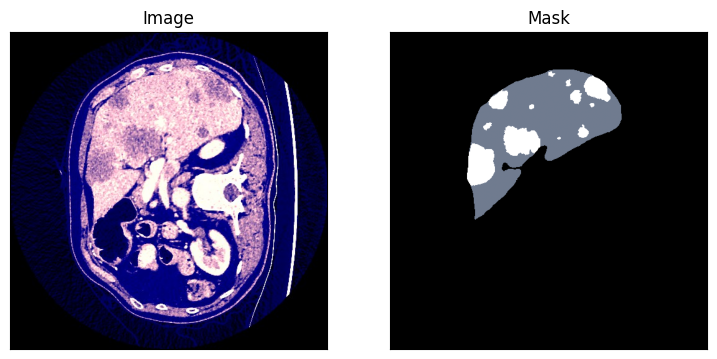

In [ ]:
if __name__ == "__main__":

    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    i = random.randint(0, 6100)

    """ Dataset """
    train_frame_path = '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan'
    train_mask_path = '/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks'

    (train_x, train_y), (valid_x, valid_y) = load_data(train_frame_path, train_mask_path)

    visualize(image = read_image(train_x[i]), mask = read_mask(train_y[i]))


    #hyperparameters
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    IMG_CHANNELS = 3
    n_classes = 3
    #weights = [0.35983807, 6.597887, 14.40744607]

    lr = 1e-4
    batch_size = 4
    epochs = 5


In [ ]:
import tensorflow as tf

try:
    # Detect if a TPU is available
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU", tpu.master())
except ValueError:
    # If TPU is not found, default to GPU or CPU
    print("Running on GPU or CPU")

# Place your model creation and training code here

Running on TPU 


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Define a Swin Transformer Block
def swin_transformer_block(x, num_blocks=2, embed_dim=96, num_heads=4, window_size=7):
    for _ in range(num_blocks):
        x = Conv2D(embed_dim, (3, 3), padding="same", activation="relu")(x)
    return x

# Define Patch Merging for downsampling
def patch_merging(x, embed_dim=96):
    x = Conv2D(embed_dim, (2, 2), strides=(2, 2), padding="same")(x)
    return x

# Define Patch Expanding for upsampling
def patch_expanding(x, embed_dim=96):
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(embed_dim, (3, 3), padding="same", activation="relu")(x)
    return x

# SwinUNet Model function
def swin_unet_model(input_shape=(512, 512, 3), n_classes=3):
    inputs = Input(input_shape)

    # Encoder
    x = Dense(96)(inputs)  # Initial embedding layer

    # First Level of Encoder
    x1 = swin_transformer_block(x, num_blocks=2, embed_dim=96)
    x1_p = patch_merging(x1, embed_dim=96)

    # Second Level of Encoder
    x2 = swin_transformer_block(x1_p, num_blocks=2, embed_dim=192)
    x2_p = patch_merging(x2, embed_dim=192)

    # Third Level of Encoder
    x3 = swin_transformer_block(x2_p, num_blocks=6, embed_dim=384)
    x3_p = patch_merging(x3, embed_dim=384)

    # Fourth Level of Encoder
    x4 = swin_transformer_block(x3_p, num_blocks=2, embed_dim=768)

    # Bottleneck
    bottleneck = swin_transformer_block(x4, num_blocks=2, embed_dim=768)

    # Decoder
    u1 = patch_expanding(bottleneck, embed_dim=384)
    u1 = concatenate([u1, x3])
    u1 = swin_transformer_block(u1, num_blocks=2, embed_dim=384)

    u2 = patch_expanding(u1, embed_dim=192)
    u2 = concatenate([u2, x2])
    u2 = swin_transformer_block(u2, num_blocks=2, embed_dim=192)

    u3 = patch_expanding(u2, embed_dim=96)
    u3 = concatenate([u3, x1])
    u3 = swin_transformer_block(u3, num_blocks=2, embed_dim=96)

    # Output Layer
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(u3)

    # Create model
    model = Model(inputs=[inputs], outputs=[outputs])

    return model
# Instantiate the model
model = swin_unet_model(input_shape=(512, 512, 3), n_classes=3)

# Generate a one-line summary of layer names and shapes
layer_summary = " | ".join([f"{layer.name}: {layer.output.shape}" for layer in model.layers if hasattr(layer.output, 'shape')])

# Print the summary
print(layer_summary)



input_layer_2: (None, 512, 512, 3) | dense_2: (None, 512, 512, 96) | conv2d_54: (None, 512, 512, 96) | conv2d_55: (None, 512, 512, 96) | conv2d_56: (None, 256, 256, 96) | conv2d_57: (None, 256, 256, 192) | conv2d_58: (None, 256, 256, 192) | conv2d_59: (None, 128, 128, 192) | conv2d_60: (None, 128, 128, 384) | conv2d_61: (None, 128, 128, 384) | conv2d_62: (None, 128, 128, 384) | conv2d_63: (None, 128, 128, 384) | conv2d_64: (None, 128, 128, 384) | conv2d_65: (None, 128, 128, 384) | conv2d_66: (None, 64, 64, 384) | conv2d_67: (None, 64, 64, 768) | conv2d_68: (None, 64, 64, 768) | conv2d_69: (None, 64, 64, 768) | conv2d_70: (None, 64, 64, 768) | up_sampling2d_6: (None, 128, 128, 768) | conv2d_71: (None, 128, 128, 384) | concatenate_6: (None, 128, 128, 768) | conv2d_72: (None, 128, 128, 384) | conv2d_73: (None, 128, 128, 384) | up_sampling2d_7: (None, 256, 256, 384) | conv2d_74: (None, 256, 256, 192) | concatenate_7: (None, 256, 256, 384) | conv2d_75: (None, 256, 256, 192) | conv2d_76: (No

In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch = batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch = batch_size)


In [ ]:
train_steps = len(train_x)//batch_size
valid_steps = len(valid_x)//batch_size

history_class = LossHistory()

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callbacks = [
    ModelCheckpoint("Multiclass-Semantic_one_hot_encoder_catcross_SNet.keras",
                    monitor='val_loss',
                    save_best_only=True,  # Save only the best model
                    verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    #EarlyStopping(monitor="val_loss", patience=3, verbose=1, min_delta=0.001),
]

In [ ]:
# In your model compilation step
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr), metrics = ['accuracy', dice_coef_3Class, tf.keras.metrics.OneHotMeanIoU(num_classes=3)] )

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=4,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(None, 512, 512, 3), output.shape=(None, 512, 512, 3)

In [ ]:
model.save('Final_model_Multiclass-Semantic_one_hot_encoder_catcross_SNET.keras')

In [ ]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
def plot_segm_history_acc(history, metrics=["accuracy", "val_accuracy"], losses=["loss", "val_loss"]):
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)

    #plt.suptitle("Accuracy V epochs", fontsize=20)
    plt.ylabel("Accuracy", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
      # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_segm_history_acc(history)

In [ ]:
def plot_segm_history_dice(history, metrics=["dice_coef_3_class", "val_dice_coef_3_class"], losses=["loss", "val_loss"]): # Changed metrics to dice_coef and val_dice_coef
    #plt.style.use(['science', 'no-latex'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        if metric in history.history: # Check if the metric exists in the history
            plt.plot(history.history[metric], linewidth=3)
        else:
            print(f"Metric '{metric}' not found in history.")
    #plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("Dice Coefficient 3 Class", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

plot_segm_history_dice(history)

In [ ]:
os.mkdir('/content/val_masks')
os.listdir('./')

In [ ]:
from tqdm import tqdm
from PIL import Image

for x in tqdm(valid_x, total = len(valid_x), position = 0, leave=True):
    name = x.split('/')[-1]
    name = name.replace('.jpg', '.tiff')

    x = read_image(x)

    p = model.predict(np.expand_dims(x,axis=0))[0]
    p = np.argmax(p, axis=-1)
    #print(np.unique(p, return_counts=True))
    p = np.expand_dims(p, axis=-1)
    p = p.astype(np.int32)
    p = np.squeeze(p, axis=-1)

    img = Image.fromarray(p.astype('uint8'), mode = 'L')
    img.save(f"./val_masks/{name}")

In [ ]:
valid_masks =[]
for filename in os.listdir('./val_masks'):
    valid_masks.append(f"./val_masks"+'/'+filename)
print(valid_masks[0:5])

In [ ]:
valid_x = list(map(lambda x : x.replace('.tiff', '.jpg'), valid_masks))
valid_x = list(map(lambda x : x.replace('./val_masks/','/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan/'), valid_x))
valid_x[0:10]

In [ ]:
valid_y = list(map(lambda x : x.replace('./val_masks/','/content/multiclass-semantic-ct-scan-liver-tumor/Train_Ct-Scan_masks/'), valid_masks))
valid_y[0:10]

In [ ]:
import random

l = random.sample(range(0,1078), 10)


for i in l:
    visualize(image = read_image(valid_x[i]), mask = read_mask(valid_y[i]), generated_mask = read_mask(valid_masks[i]))

valid_x[0:10]